# Trabalho Prático III - Fundamentos de Inteligência Artificial
**Universidade Federal de Minas Gerais (UFMG)**

**Departamento de Engenharia Elétrica**

**Professores:** Cristiano Castro e João Paulo Lara

**Grupo:**



## 1. Controle de um Robô via Q-Learning

Problema de navegação de um robô em um laboratório químico simulado (Grid 4x4) utilizando Aprendizado por Reforço (**Q-Learning**).

### Definições do Ambiente
O ambiente é um grid $4 \times 4$.
*   **Estados:** Coordenadas $(linha, coluna)$.
*   **Ações:** Cima (0), Direita (1), Baixo (2), Esquerda (3).
*   **Recompensas:**
    *   Passo em vazio: $-1$
    *   Lama (Atola): $-5$
    *   Substância Tóxica: $-20$ (Estado Terminal)
    *   Saída: $+20$ (Estado Terminal)

### Parâmetros do Algoritmo
*   $\alpha$ (Learning Rate): $0.2$
*   $\gamma$ (Discount Factor): $0.95$
*   $\epsilon$ (Epsilon-greedy): $0.1$
*   Episódios: $100$
*   Máx. iterações por episódio: $10$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(646)
np.random.seed(589)

## 2. Modelagem do Problema
Mapeamento visual para Matriz (Linha, Coluna):
*   A matriz é indexada de (0,0) no topo-esquerdo até (3,3) na base-direita.
*   **Tóxico (Mata):** Posições (0, 1) e (3, 2).
*   **Lama (Atola):** Posições (1, 1) e (2, 3).
*   **Saída (Objetivo):** Posição (0, 3).

In [10]:
# Dimensões do Grid
N_ROWS = 4
N_COLS = 4

# Definição dos tipos de terreno para visualização e lógica
# 0: Vazio, 1: Lama, 2: Tóxico, 3: Saída
GRID_LAYOUT = np.zeros((N_ROWS, N_COLS), dtype=int)

# Preenchendo conforme a Figura 1.1

GRID_LAYOUT[0, 3] = 3
GRID_LAYOUT[0, 1] = 2 
GRID_LAYOUT[3, 2] = 2 
GRID_LAYOUT[1, 1] = 1 
GRID_LAYOUT[2, 3] = 1 

REWARDS = {
    'empty': -1,
    'mud': -5,
    'toxic': -20,
    'goal': 20
}

# Ações: 0: Cima, 1: Direita, 2: Baixo, 3: Esquerda
ACTIONS = [0, 1, 2, 3]
ACTION_NAMES = ['↑', '→', '↓', '←']
DELTA_COORDS = [(-1, 0), (0, 1), (1, 0), (0, -1)]

def is_terminal(state):
    """Verifica se o estado é terminal (Tóxico ou Saída)"""
    row, col = state
    cell_type = GRID_LAYOUT[row, col]
    return cell_type == 2 or cell_type == 3

def get_reward(state):
    """Retorna a recompensa do estado atual"""
    row, col = state
    cell_type = GRID_LAYOUT[row, col]
    
    if cell_type == 0: return REWARDS['empty']
    if cell_type == 1: return REWARDS['mud']
    if cell_type == 2: return REWARDS['toxic']
    if cell_type == 3: return REWARDS['goal']
    return REWARDS['empty']

print("Layout do Grid (0: Vazio, 1: Lama, 2: Tóxico, 3: Saída):")
print(GRID_LAYOUT)

Layout do Grid (0: Vazio, 1: Lama, 2: Tóxico, 3: Saída):
[[0 2 0 3]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 2 0]]


## 3. Funções Auxiliares e Lógica Q-Learning

Aqui implementamos:
1.  **Step:** A lógica de movimento do agente, verificando as bordas do grid.
2.  **Escolha de Ação ($\epsilon$-greedy):** Implementa a equação 1.1, incluindo o critério de desempate aleatório para valores Q iguais.

In [11]:
def step(state, action):
    """
    Executa uma ação a partir de um estado.
    Retorna: proximo_estado
    """
    row, col = state
    d_row, d_col = DELTA_COORDS[action]
    
    new_row = row + d_row
    new_col = col + d_col
    
    # Verifica limites do grid
    if 0 <= new_row < N_ROWS and 0 <= new_col < N_COLS:
        return (new_row, new_col)
    else:
        # Se bater na parede, permanece no mesmo lugar
        return state

def choose_action(Q_table, state, epsilon):
    """
    Política Epsilon-Greedy com desempate aleatório.
    """
    row, col = state
    
    # Exploração (Exploration)
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(ACTIONS)
    
    # Exploração (Exploitation)
    else:
        # Pega os valores Q para o estado atual
        q_values = Q_table[row, col, :]
        max_q = np.max(q_values)
        
        # Encontra todos os índices que possuem o valor máximo (lidando com empates)
        # O np.argmax padrão pegaria sempre o primeiro, o que enviesa o aprendizado
        ties = np.flatnonzero(q_values == max_q)
        
        return np.random.choice(ties)

def get_random_start_state():
    """Escolhe um estado inicial aleatório que não seja terminal"""
    while True:
        row = np.random.randint(0, N_ROWS)
        col = np.random.randint(0, N_COLS)
        if not is_terminal((row, col)):
            return (row, col)

## 4. Treinamento do Agente


In [12]:


def train_q_learning(alpha, gamma, epsilon, num_episodes, max_steps):
    """
    Treina o agente usando Q-Learning.
    """

    Q_table = np.zeros((N_ROWS, N_COLS, len(ACTIONS)))

    rewards_per_episode = []

  
    for episode in range(num_episodes):
        state = get_random_start_state()
        total_reward = 0
        
        for _ in range(max_steps):
            # Escolher Ação (Epsilon-Greedy)
            action = choose_action(Q_table, state, epsilon)
            next_state = step(state, action)
            reward = get_reward(next_state)
            total_reward += reward
            
            # Atualizar Q-Table 
            row, col = state
            next_row, next_col = next_state
            
            best_next_q = np.max(Q_table[next_row, next_col, :])
            
            if is_terminal(next_state):
                target = reward # Não soma o futuro pois acabou
            else:
                target = reward + gamma * best_next_q
            
            Q_table[row, col, action] = Q_table[row, col, action] + alpha * (target - Q_table[row, col, action])
            
            state = next_state
            if is_terminal(state):
                break
                
        rewards_per_episode.append(total_reward)
 

    return Q_table, rewards_per_episode

# Hiperparâmetros
alpha = 0.2
gamma = 0.95
epsilons = np.linspace(0.1, 1, num=4)
num_episodes = 100
max_steps = 10

Q_tables_list= []
rewards_list = []
for epsilon in epsilons:
    Q_table, rewards = train_q_learning(alpha, gamma, epsilon, num_episodes, max_steps)
    Q_tables_list.append(Q_table)
    rewards_list.append(rewards)

colors = [
    [0.0, 0.447, 0.741, 1.0],  
    [0.85, 0.325, 0.098, 1.0], 
    [0.929, 0.694, 0.125, 1.0],
    [0.494, 0.184, 0.556, 1.0] 
]

## 5. Análise de Resultados

Abaixo apresentamos:
1.  Gráfico de recompensa acumulada por episódio.
2.  Média móvel das recompensas para visualizar a tendência de aprendizado.

### One Execution

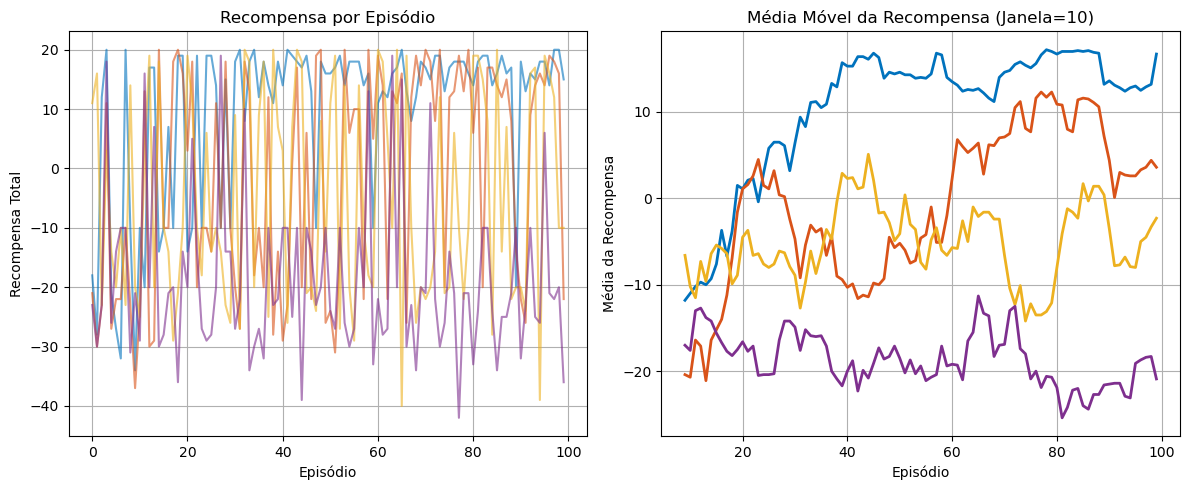

<Figure size 640x480 with 0 Axes>

In [13]:
# Cálculo da Média Móvel 
window_size = 10
moving_avg_list = [np.convolve(rewards_per_episode, np.ones(window_size)/window_size, mode='valid') for rewards_per_episode in rewards_list]

plt.figure(figsize=(12, 5))

# Recompensa Pura
plt.subplot(1, 2, 1)
for i, rewards_per_episode in enumerate(rewards_list):
    plt.plot(rewards_per_episode, alpha=0.6, color=colors[i], label=f'ε {epsilons[i]}')
plt.title('Recompensa por Episódio')
plt.xlabel('Episódio')
plt.ylabel('Recompensa Total')
plt.grid(True)

# Moving Average
plt.subplot(1, 2, 2)
for i, moving_avg in enumerate(moving_avg_list):
    plt.plot(range(window_size-1, num_episodes), moving_avg, color=colors[i], linewidth=2, label=f'ε {epsilons[i]}')
plt.title(f'Média Móvel da Recompensa (Janela={window_size})')
plt.xlabel('Episódio')
plt.ylabel('Média da Recompensa')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('plots/q_learning_rewards.png')



## Multiple Runs

Rodando 30 simulações por epsilon...


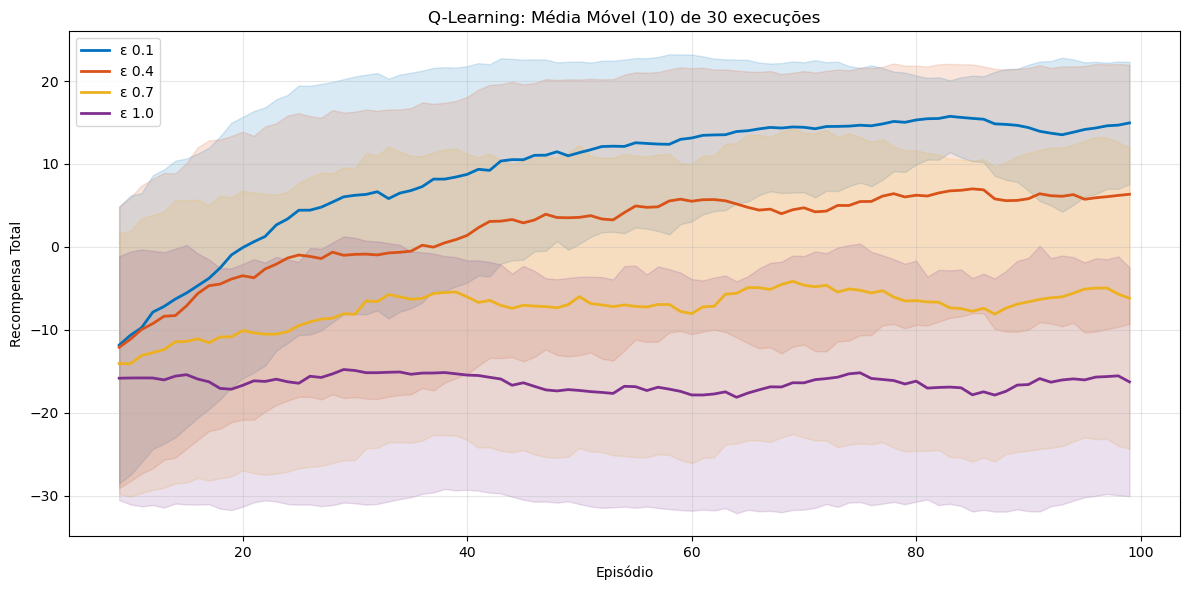

<Figure size 640x480 with 0 Axes>

In [14]:
# Hiperparâmetros
alpha = 0.2
gamma = 0.95
epsilons = np.round(np.linspace(0.1, 1, num=4),2)
num_episodes = 100
max_steps = 10


num_runs = 30
window_size = 10    # Janela da média móvel

# Dicionário para guardar os dados : {epsilon: matrix(num_runs X num_episodes)}
results_data = {}

print(f"Rodando {num_runs} simulações por epsilon...")

for epsilon in epsilons:
    rewards_matrix = np.zeros((num_runs, num_episodes))
    for r in range(num_runs):
        _, rewards = train_q_learning(alpha, gamma, epsilon, num_episodes, max_steps)
        rewards_matrix[r, :] = rewards
    results_data[epsilon] = rewards_matrix


plt.figure(figsize=(12, 6))

for i, epsilon in enumerate(epsilons):
    data = results_data[epsilon] 
    

    mean_per_episode = np.mean(data, axis=0)
    std_per_episode = np.std(data, axis=0)
    
    #Aplicar Média Móvel

    kernel = np.ones(window_size) / window_size
    
    smooth_mean = np.convolve(mean_per_episode, kernel, mode='valid')
    smooth_std = np.convolve(std_per_episode, kernel, mode='valid')
    
    x_axis = np.arange(window_size - 1, num_episodes)
    
    c = colors[i % len(colors)]
    

    plt.plot(x_axis, smooth_mean, color=c, label=f'ε {epsilon}', linewidth=2)
    plt.fill_between(x_axis, 
                     smooth_mean - smooth_std, 
                     smooth_mean + smooth_std, 
                     color=c, alpha=0.15)

plt.title(f'Q-Learning: Média Móvel ({window_size}) de {num_runs} execuções')
plt.xlabel('Episódio')
plt.ylabel('Recompensa Total')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('plots/q_learning_rewards_avg.png')

## 6. Visualização da Política Ótima


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch


def save_policy_image(Q, GRID_LAYOUT, ACTION_NAMES, filename="policy.png"):

    N_ROWS, N_COLS = GRID_LAYOUT.shape

    fig, ax = plt.subplots(figsize=(N_COLS, N_ROWS))

    # Map para vetores das ações
    DIR_VECTORS = {
        "↑": (0, 0.35),
        "↓": (0, -0.35),
        "←": (-0.35, 0),
        "→": (0.35, 0)
    }

    for r in range(N_ROWS):
        for c in range(N_COLS):
            cell = GRID_LAYOUT[r, c]

            # Cores
            if cell == 1:
                color = "#d2a679"      # lama
            elif cell == 2:
                color = "#ff6666"      # tóxico
            elif cell == 3:
                color = "#66ff66"      # saída
            else:
                color = "#ffffff"      # normal

            y = N_ROWS - r - 1
            ax.add_patch(
                patches.Rectangle((c, y), 1, 1, facecolor=color, edgecolor="black")
            )

            # Conteúdo da célula
            if cell == 2:
                ax.text(c + 0.5, y + 0.5, "☢️", fontsize=26, ha='center', va='center')
                continue

            if cell == 3:
                ax.text(c + 0.5, y + 0.5, "🚪", fontsize=26, ha='center', va='center')
                continue

            # Melhor ação
            best = np.argmax(Q[r, c])
            action = ACTION_NAMES[best]
            best_value = Q[r, c, best]

            dx, dy = DIR_VECTORS[action]

            # Desenha a seta
            arrow = FancyArrowPatch(
                (c + 0.5, y + 0.5),
                (c + 0.5 + dx, y + 0.5 + dy),
                arrowstyle='-|>',
                mutation_scale=30,
                linewidth=3,
                color='black'
            )
            ax.add_patch(arrow)

            # Desenha o valor da ação
            ax.text(
                c + 0.5, y + 0.2,
                f"{best_value:.2f}",
                fontsize=12,
                ha='center',
                va='center'
            )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, N_COLS)
    ax.set_ylim(0, N_ROWS)
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

    print(f"Imagem salva como: {filename}")


In [16]:

save_policy_image(Q_table, GRID_LAYOUT, ACTION_NAMES, filename="plots/learned_policy.png")

Imagem salva como: plots/learned_policy.png


/tmp/ipykernel_189108/90942756.py:82: UserWarning: Glyph 128682 (\N{DOOR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189108/90942756.py:83: UserWarning: Glyph 128682 (\N{DOOR}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=200)
